In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE



In [35]:
df_raw = pd.read_csv('adult_1.csv')
df_clean = pd.read_csv('adult_2.csv')

بررسی تفاوت دیتاست ها

DATA RAW:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50064 entries, 0 to 50063
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             47570 non-null  object 
 1   workclass       38154 non-null  object 
 2   fnlwgt          37383 non-null  float64
 3   education       38128 non-null  object 
 4   education-num   38468 non-null  object 
 5   marital-status  38105 non-null  object 
 6   occupation      38097 non-null  object 
 7   relationship    38119 non-null  object 
 8   race            38102 non-null  object 
 9   sex             38170 non-null  object 
 10  capital-gain    50063 non-null  object 
 11  capital-loss    45282 non-null  float64
 12  hours-per-week  37400 non-null  float64
 13  native-country  38134 non-null  object 
 14  income          50063 non-null  object 
dtypes: float64(3), object(12)
memory usage: 5.7+ MB
None

DESCRIBE:
          age workclass        fnlwgt education

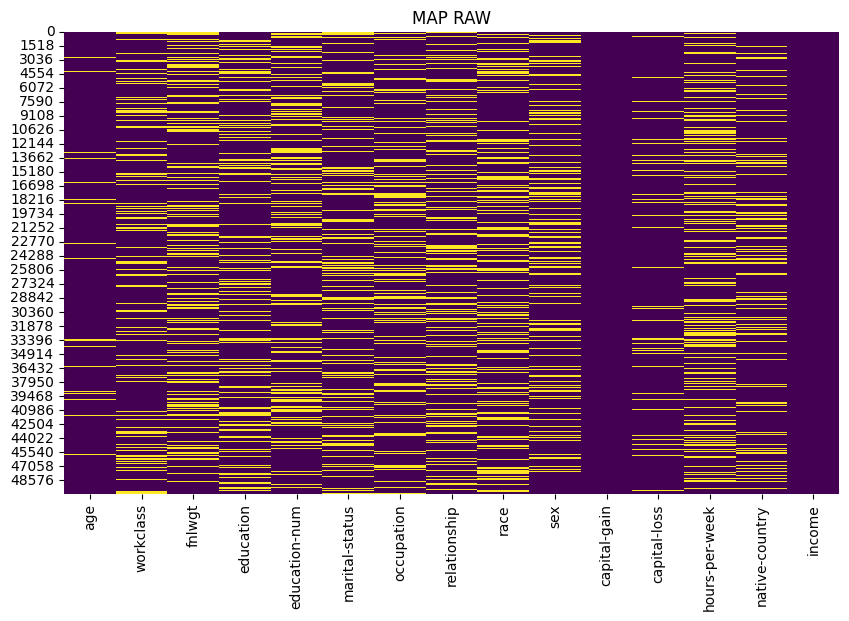

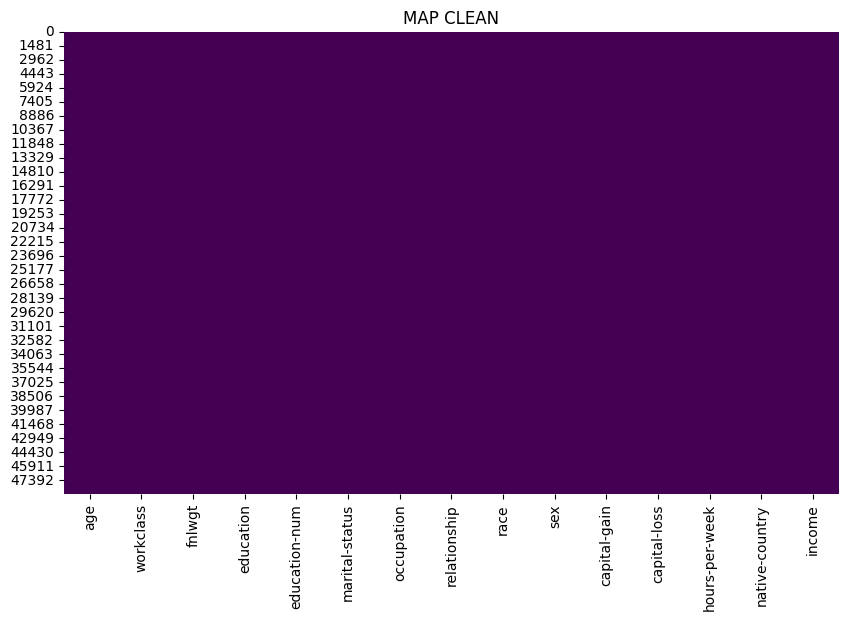

In [36]:
# بررسی اولیه دیتاست خام
print("DATA RAW:")
print(df_raw.info())
print("\nDESCRIBE:")
print(df_raw.describe(include='all'))
print("\nMISSING VALUES")
print(df_raw.isnull().sum())

# بررسی اولیه دیتاست تمیز شده
print("\nDATA CLEAN:")
print(df_clean.info())
print("\nDESCRIBE:")
print(df_clean.describe(include='all'))
print("\nMISSING VALUES:")
print(df_clean.isnull().sum())

plt.figure(figsize=(10, 6))
sns.heatmap(df_raw.isnull(), cbar=False, cmap='viridis')
plt.title('MAP RAW')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis')
plt.title('MAP CLEAN')
plt.show()

1- تحلیل آماری اولیه

محاسبه ماتریس کوواریانس

clean matrix:
                      fnlwgt  education-num  capital-gain   capital-loss  \
fnlwgt          1.115221e+10  -10523.722187 -2.916791e+06 -185818.540554   
education-num  -1.052372e+04       6.609901  2.397673e+03      83.896136   
capital-gain   -2.916791e+06    2397.673247  5.553259e+07  -94422.847037   
capital-loss   -1.858185e+05      83.896136 -9.442285e+04  162412.669033   
hours-per-week -1.769041e+04       4.577651  7.586508e+03     271.998838   

                hours-per-week  
fnlwgt           -17690.405781  
education-num         4.577651  
capital-gain       7586.507972  
capital-loss        271.998838  
hours-per-week      153.547885  

matrix shape: (5, 5)


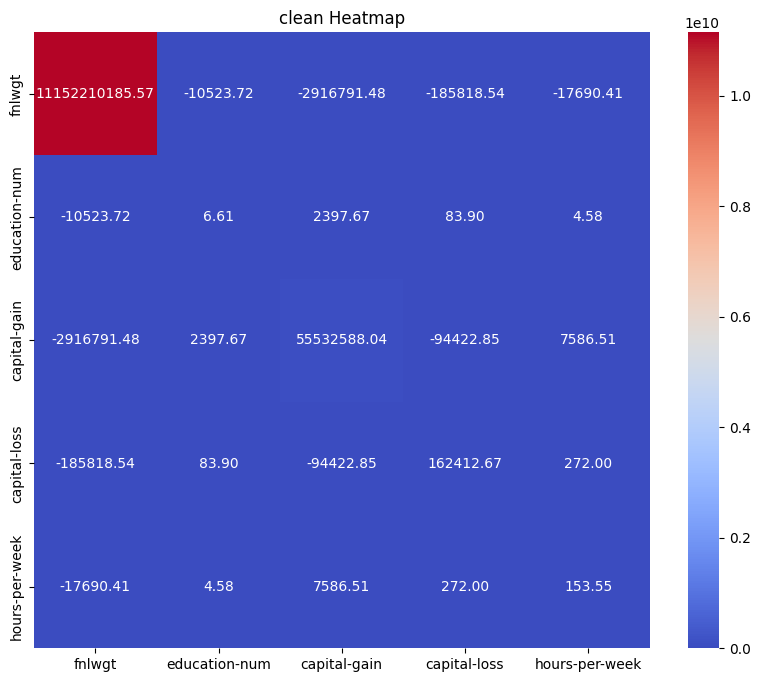

In [37]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean_numeric = df_clean[numeric_cols]

cov_matrix = df_clean_numeric.cov()

print("clean matrix:")
print(cov_matrix)

print("\nmatrix shape:", cov_matrix.shape)

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('clean Heatmap')
plt.show()

تحلیل همبستگی بین ویژگی‌ها

corr matrix for clean:
                  fnlwgt  education-num  capital-gain  capital-loss  \
fnlwgt          1.000000      -0.038761     -0.003706     -0.004366   
education-num  -0.038761       1.000000      0.125146      0.080972   
capital-gain   -0.003706       0.125146      1.000000     -0.031441   
capital-loss   -0.004366       0.080972     -0.031441      1.000000   
hours-per-week -0.013519       0.143689      0.082157      0.054467   

                hours-per-week  
fnlwgt               -0.013519  
education-num         0.143689  
capital-gain          0.082157  
capital-loss          0.054467  
hours-per-week        1.000000  


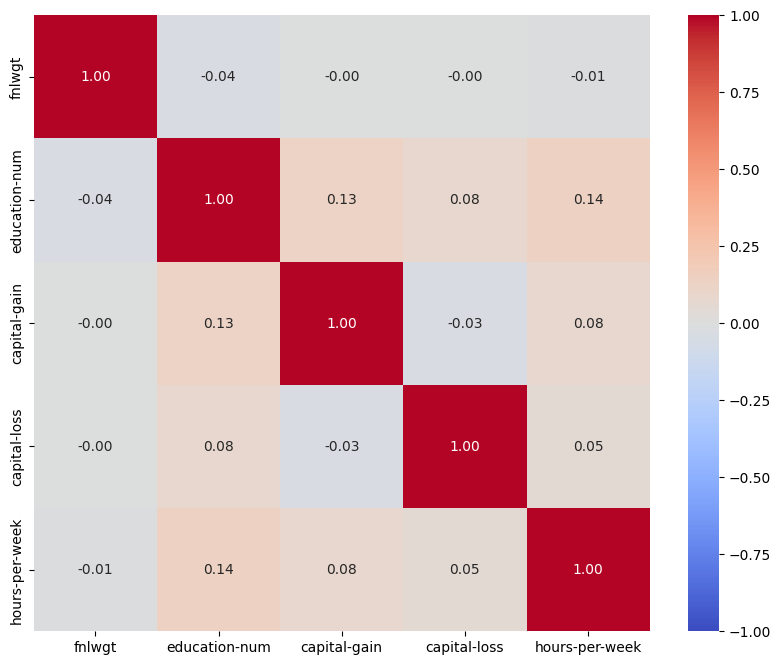


 high corr pairs: (for example higher than 0.8)


In [38]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean_numeric = df_clean[numeric_cols]

corr_matrix = df_clean_numeric.corr()

print("corr matrix for clean:")
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.show()

high_corr_threshold = 0.8
high_corr_pairs = np.where(np.abs(corr_matrix) > high_corr_threshold)
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]) 
                   for i, j in zip(*high_corr_pairs) if i != j]

print("\n high corr pairs: (for example higher than 0.8)")
for pair in high_corr_pairs:
    print(f"Features: {pair[0]} و {pair[1]} - Solidarity: {pair[2]:.2f}")

2- کاهش ابعاد داده ها

 PCA(تحلیل مؤلفه های اصلی)

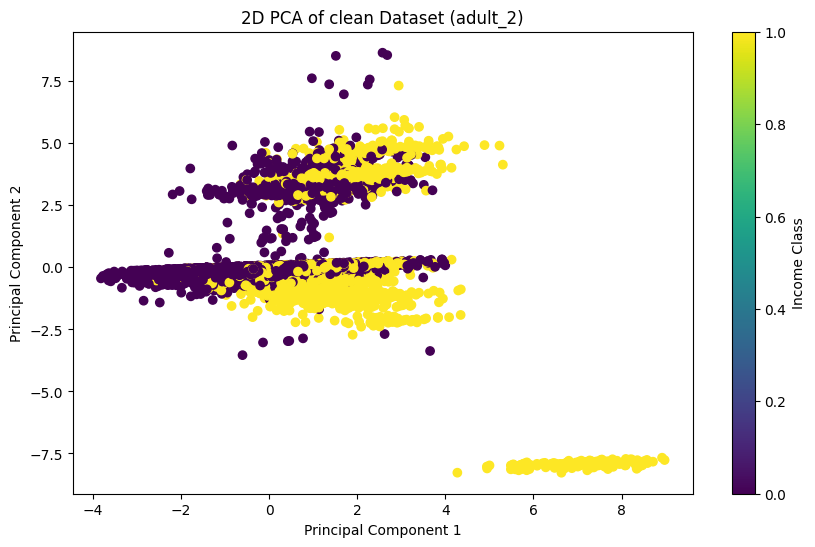

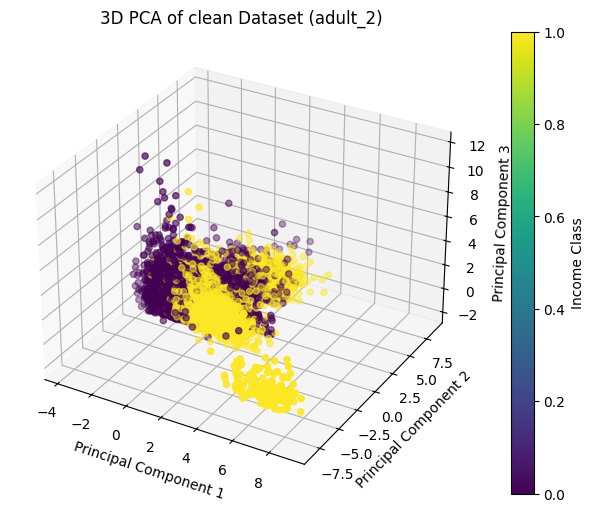

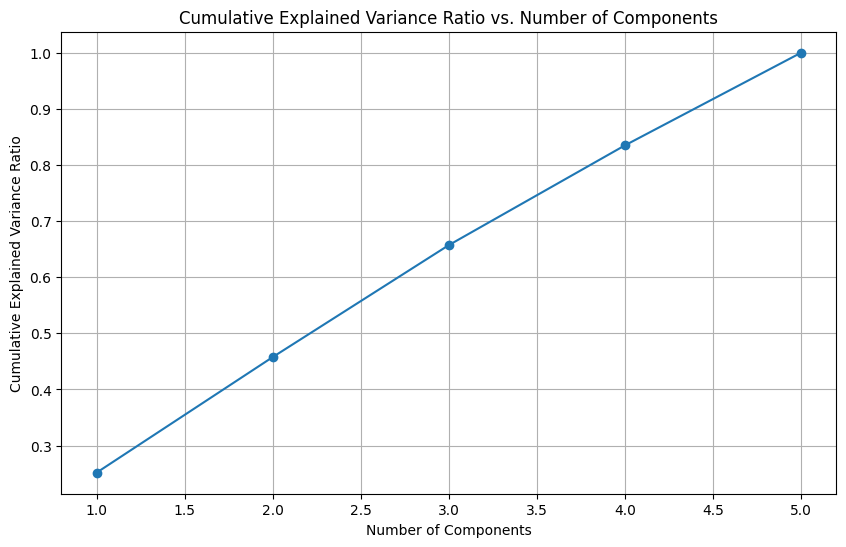

Explanatory variance for each component: [0.25169763 0.20593455 0.19954036 0.17776117 0.16506629]
Cumulative explanatory variance: [0.25169763 0.45763218 0.65717254 0.83493371 1.        ]


In [39]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
X = df_clean[numeric_cols]

#Convert labels to numbers (if needed)
if 'income' in df_clean.columns:
    y = df_clean['income']  
    label_encoded = y.map({'<=50K': 0, '>50K': 1})  
else:
    y = None
    print("Dataset has no labels, graph will be drawn without class coloring.")

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)  

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# کاهش ابعاد به بعدهای مختلف (اینجا به 2 و 3 بعد)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
if y is not None:
    scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=label_encoded, cmap='viridis')
    plt.colorbar(scatter, label='Income Class')
else:
    plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1])
plt.title('2D PCA of clean Dataset (adult_2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
if y is not None:
    scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=label_encoded, cmap='viridis')
    plt.colorbar(scatter, label='Income Class')
else:
    ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2])
ax.set_title('3D PCA of clean Dataset (adult_2)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()


# نمودار واریانس توضیح‌دهنده برای انتخاب ابعاد
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid()
plt.show()

# نمایش درصد واریانس توضیح‌دهنده برای هر مؤلفه
print("Explanatory variance for each component:", explained_variance_ratio)
print("Cumulative explanatory variance:", cumulative_explained_variance)


 PCA Kernel با کرنل دلخواه
 

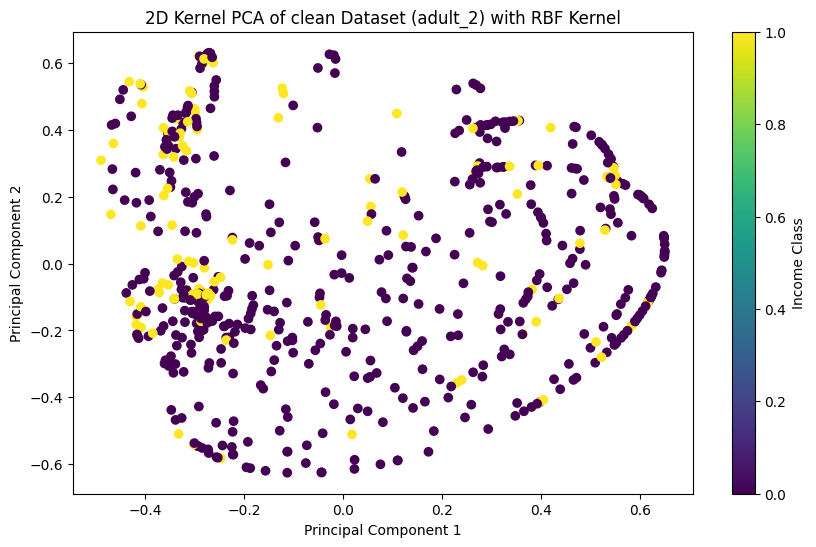

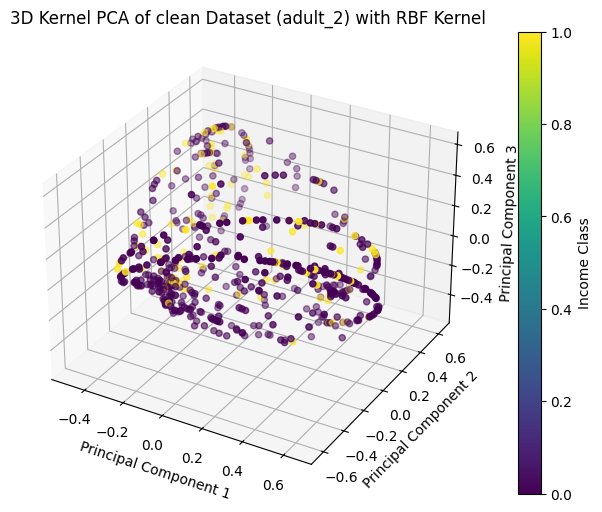

Explained variance ratio is not directly available in this version of scikit-learn for Kernel PCA.
Use visual inspection of the 2D and 3D plots to assess the quality of the dimensionality reduction.


In [40]:

# Load the raw dataset (use a sample if too large)
df_clean = pd.read_csv('adult_2.csv').sample(n=1000, random_state=42)  # Sample 1000 rows

# Select numerical columns (features)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
X = df_clean[numeric_cols]

# Check for labels (assuming 'income' as the label column, if it exists)
if 'income' in df_clean.columns:
    y = df_clean['income']
    label_encoded = y.map({'<=50K': 0, '>50K': 1})
else:
    y = None
    print("No labels found in the dataset, the plot will be drawn without class coloring.")

# Handle missing values using SimpleImputer (impute with mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply Kernel PCA with optimized parameters
kpca_2d = KernelPCA(n_components=2, kernel='rbf', gamma=0.5, random_state=42)
X_kpca_2d = kpca_2d.fit_transform(X_scaled)

kpca_3d = KernelPCA(n_components=3, kernel='rbf', gamma=0.5, random_state=42)
X_kpca_3d = kpca_3d.fit_transform(X_scaled)

# Plot 2D and 3D scatter plots
# 2D Plot
plt.figure(figsize=(10, 6))
if y is not None:
    scatter = plt.scatter(X_kpca_2d[:, 0], X_kpca_2d[:, 1], c=label_encoded, cmap='viridis')
    plt.colorbar(scatter, label='Income Class')
else:
    plt.scatter(X_kpca_2d[:, 0], X_kpca_2d[:, 1])
plt.title('2D Kernel PCA of clean Dataset (adult_2) with RBF Kernel')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
if y is not None:
    scatter = ax.scatter(X_kpca_3d[:, 0], X_kpca_3d[:, 1], X_kpca_3d[:, 2], c=label_encoded, cmap='viridis')
    plt.colorbar(scatter, label='Income Class')
else:
    ax.scatter(X_kpca_3d[:, 0], X_kpca_3d[:, 1], X_kpca_3d[:, 2])
ax.set_title('3D Kernel PCA of clean Dataset (adult_2) with RBF Kernel')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

# Note: Explained variance ratio is not available in this version of scikit-learn
print("Explained variance ratio is not directly available in this version of scikit-learn for Kernel PCA.")
print("Use visual inspection of the 2D and 3D plots to assess the quality of the dimensionality reduction.")

SNE یا t-SNE 


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


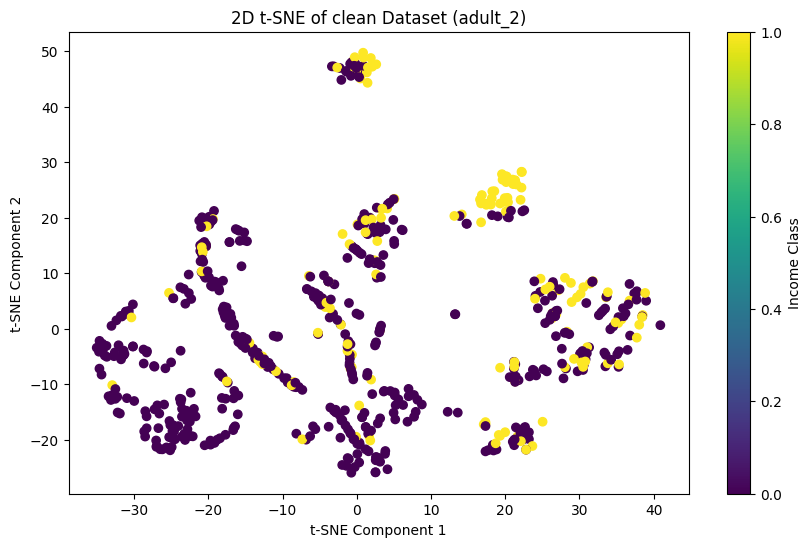

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


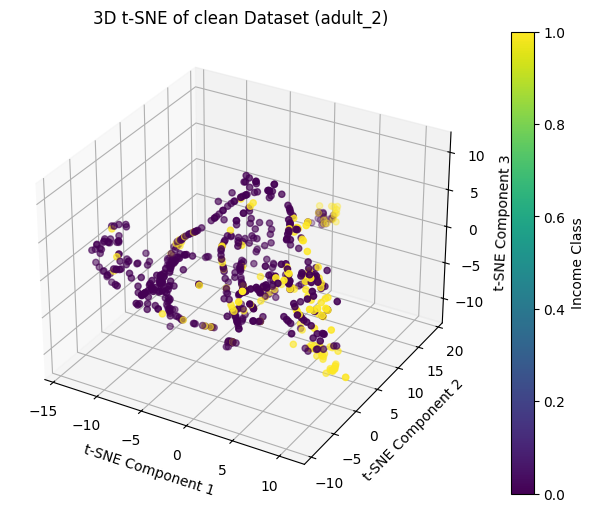

t-SNE does not provide explained variance ratio. Use visual inspection and perplexity tuning.


In [41]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
X = df_clean[numeric_cols]

if 'income' in df_clean.columns:
    y = df_clean['income']  # Labels
    label_encoded = y.map({'<=50K': 0, '>50K': 1})  # Encode labels
else:
    y = None
    print("No labels found in the dataset, the plot will be drawn without class coloring.")

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)  # 2D
X_tsne_2d = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
if y is not None:
    scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=label_encoded, cmap='viridis')
    plt.colorbar(scatter, label='Income Class')
else:
    plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1])
plt.title('2D t-SNE of clean Dataset (adult_2)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)  # 3D
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
if y is not None:
    scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=label_encoded, cmap='viridis')
    plt.colorbar(scatter, label='Income Class')
else:
    ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2])
ax.set_title('3D t-SNE of clean Dataset (adult_2)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()

print("t-SNE does not provide explained variance ratio. Use visual inspection and perplexity tuning.")



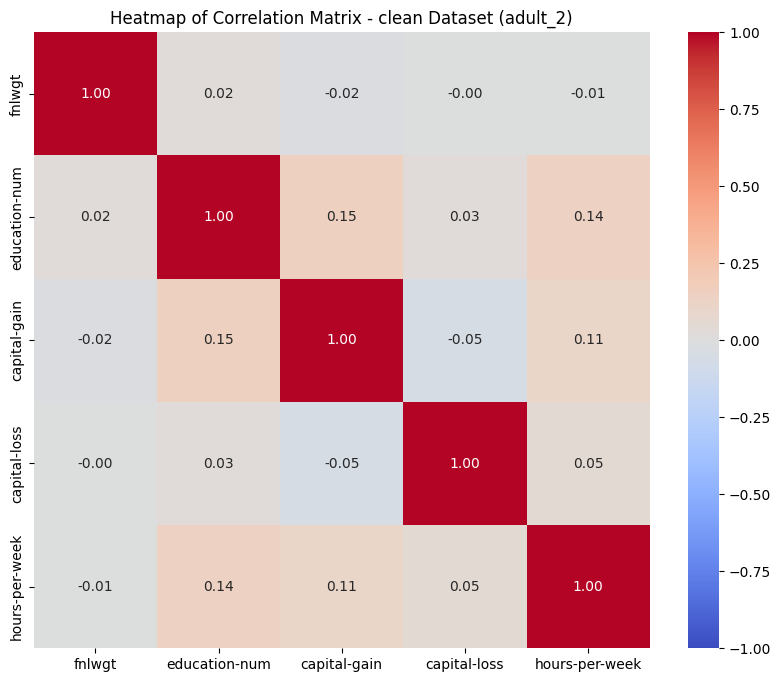

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


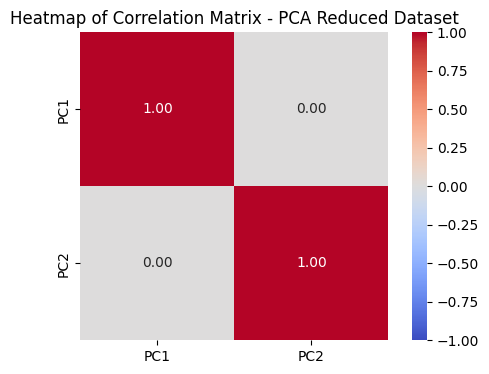

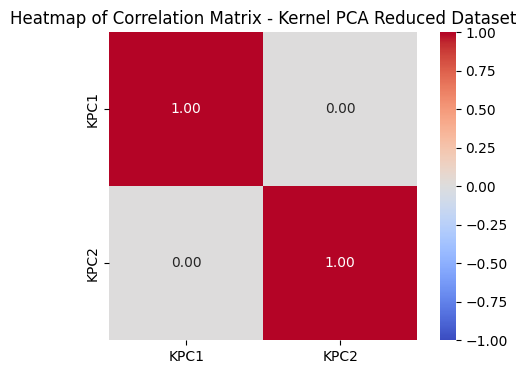

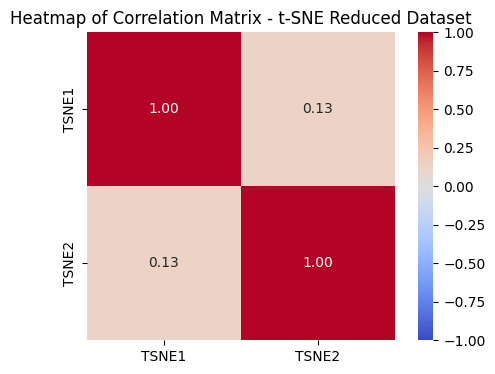

In [42]:
# Load the raw dataset (use a sample if too large)
df_clean = pd.read_csv('adult_2.csv').sample(n=1000, random_state=42)  # Sample 1000 rows

# Select numerical columns (features)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
X = df_clean[numeric_cols]

# Handle missing values using SimpleImputer (impute with mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 1. Recalculate the correlation matrix for the raw dataset (for comparison)
corr_matrix_clean = pd.DataFrame(X_scaled, columns=numeric_cols).corr()

# Plot the heatmap for the raw dataset (initial heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_clean, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix - clean Dataset (adult_2)')
plt.show()

# 2. Apply dimensionality reduction methods (PCA, Kernel PCA, t-SNE)
# PCA (2D)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Kernel PCA (2D)
kpca_2d = KernelPCA(n_components=2, kernel='rbf', gamma=0.5, random_state=42)
X_kpca_2d = kpca_2d.fit_transform(X_scaled)

# t-SNE (2D)
tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne_2d = tsne_2d.fit_transform(X_scaled)

# 3. Calculate the correlation matrix for the reduced datasets
# PCA
corr_matrix_pca = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2']).corr()

# Kernel PCA
corr_matrix_kpca = pd.DataFrame(X_kpca_2d, columns=['KPC1', 'KPC2']).corr()

# t-SNE
corr_matrix_tsne = pd.DataFrame(X_tsne_2d, columns=['TSNE1', 'TSNE2']).corr()

# 4. Plot the heatmaps for the reduced datasets
# Heatmap for PCA
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_pca, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix - PCA Reduced Dataset')
plt.show()

# Heatmap for Kernel PCA
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_kpca, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix - Kernel PCA Reduced Dataset')
plt.show()

# Heatmap for t-SNE
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_tsne, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix - t-SNE Reduced Dataset')
plt.show()